<a href="https://colab.research.google.com/github/adriano06-tech/algoritmo_de_recomendacao_de_filmes/blob/main/sistema_de_recomendacao_de_filmes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entendendo o projeto

## Dados

Para esse projeto de criar um sistema de recomendação usaremos os dados do <a href="https://grouplens.org/datasets/movielens/">MovieLens</a>. Para termos melhor performance utilizaremos primeiramente o conjunto de dados menor.

## Ideia do algoritmo

Criaremos uma versão do algoritmo <a href="https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm">KNN - (k-nearest neighbors)</a> procurando usuários com um perfil próximo do nosso usuário.

# Importando bibliotecas que utilizaremos

In [1]:
import pandas as pd
import numpy as np
SEED = 101
np.random.seed(SEED)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize': (12, 6)})
print('As bibliotecas foram importadas com sucesso')

As bibliotecas foram importadas com sucesso


# Conhecendo os dados do movielens

Os nossos dados estão separados entre um dataset dos filmes, e outro dataset de todos os votos

## Dataset dos filmes

In [2]:
movies = pd.read_csv('https://raw.githubusercontent.com/adriano06-tech/algoritmo_de_recomendacao_de_filmes/main/data/movielens/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
print(f'Temos {movies.shape[0]} linhas e {movies.shape[1]} colunas')

Temos 9742 linhas e 3 colunas


In [4]:
print(f'Temos {movies.isna().sum().sum()} dados nulos')

Temos 0 dados nulos


Vamos transformar o id do filme como índice para facilitar a usarmos esse dataset

In [5]:
movies.set_index('movieId', inplace = True)
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


## Dataset das notas

In [6]:
ratings = pd.read_csv('https://raw.githubusercontent.com/adriano06-tech/algoritmo_de_recomendacao_de_filmes/main/data/movielens/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
print(f'Temos {ratings.shape[0]} linhas e {ratings.shape[1]} colunas')

Temos 100836 linhas e 4 colunas


In [8]:
print(f'Temos {ratings.isna().sum().sum()} dados nulos')

Temos 0 dados nulos


# Juntando os dados dos filmes e as notas

In [9]:
movie_ratings = ratings.groupby('movieId').agg(['mean', 'count'])['rating']
movie_ratings.columns = ['rating', 'n_ratings']
movie_ratings.head()

,rating,n_ratings
movieId,,
1,3.920930,215
2,3.431818,110
3,3.259615,52
4,2.357143,7
5,3.071429,49


In [10]:
movies = movies.join(movie_ratings)
movies.head()

,title,genres,rating,n_ratings
movieId,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.920930,215.0
2,Jumanji (1995),Adventure|Children|Fantasy,3.431818,110.0
3,Grumpier Old Men (1995),Comedy|Romance,3.259615,52.0
4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.357143,7.0
5,Father of the Bride Part II (1995),Comedy,3.071429,49.0


# Explorando os dados juntados

## Notas

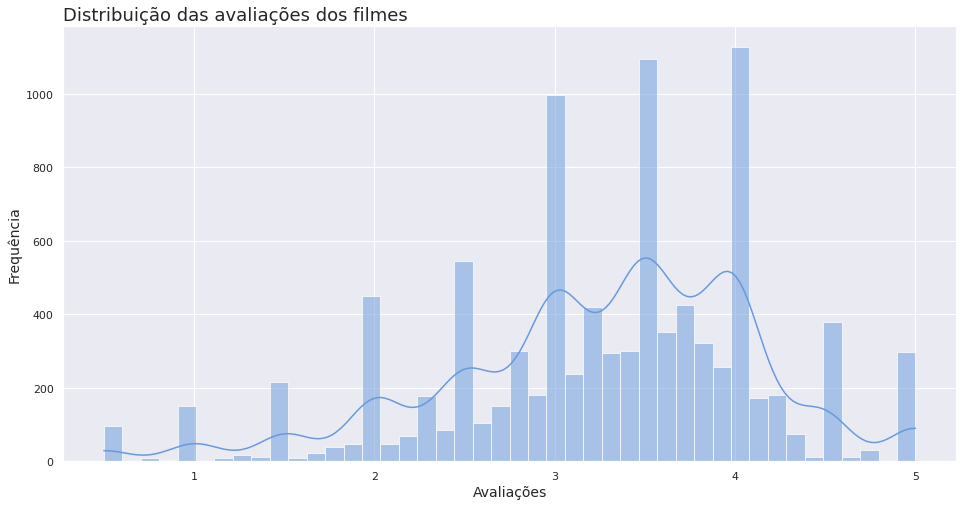

In [16]:
palette = sns.dark_palette("#69d", reverse=True)

ax = sns.histplot(
    x = 'rating',
    kde = True,
    color = palette[0],
    data = movies
)
ax.set_title('Distribuição das avaliações dos filmes', fontsize = 18, loc = 'left')
ax.set_xlabel('Avaliações', fontsize = 14)
ax.set_ylabel('Frequência', fontsize=  14)
ax.figure.set_size_inches(16, 8)
ax = ax

## Quantidade de avaliações

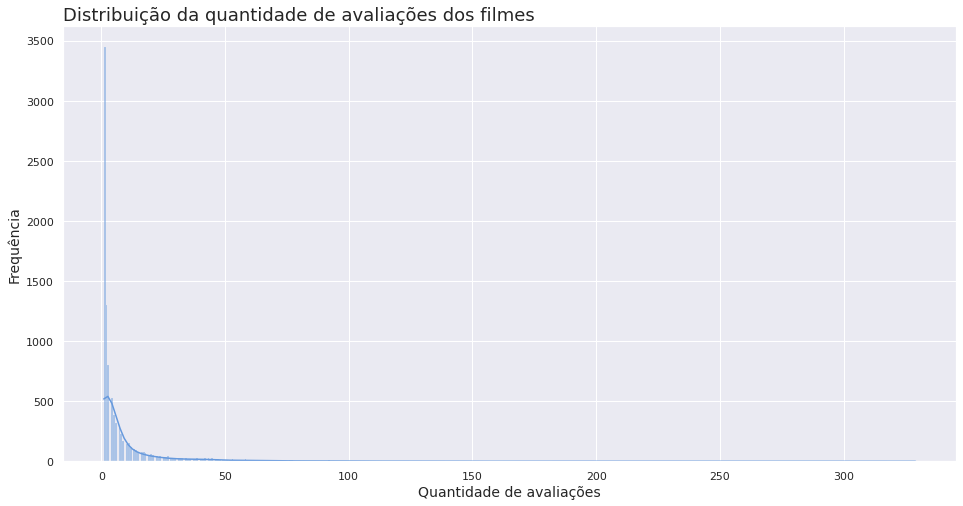

In [17]:
ax = sns.histplot(
    x = 'n_ratings',
    kde = True,
    color = palette[0],
    data = movies
)
ax.set_title('Distribuição da quantidade de avaliações dos filmes', fontsize = 18, loc = 'left')
ax.set_ylabel('Frequência', fontsize = 14)
ax.set_xlabel('Quantidade de avaliações', fontsize = 14)
ax.figure.set_size_inches(16, 8)
ax = ax

Percebemos que muitos filmes tem poucas avaliações

# Entendendo como funcionará o nosso algoritmo

<h3 style="font-weight: bold;">Vamos supor dois usuários do nosso sistema:</h3><br>
<p>João deu nota 5 para o Toy Story e 3.5 para Deadpool</p>
<p>Maria, por outro lado, deu nota 3 para o Toy Story e 4 para o Deadpool</p>

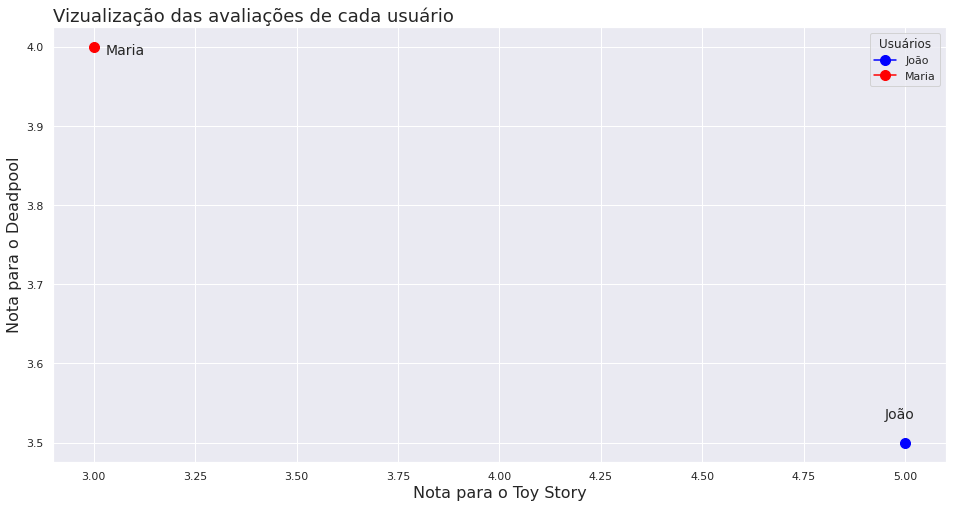

In [20]:
joao = [5, 3.5]
maria = [3, 4]
plt.figure(figsize = (16, 8))
plt.plot(joao[0], joao[1], marker = 'o', color = 'blue', markersize = 10)
plt.annotate('João', xy = (joao[0] - 0.05, joao[1] + 0.03), fontsize = 14)
plt.plot(maria[0], maria[1], marker = 'o', color = 'red', markersize = 10)
plt.annotate('Maria', xy = (maria[0] + 0.03, maria[1] - 0.01), fontsize = 14)

plt.legend(['João', 'Maria'], title = 'Usuários')
plt.title('Vizualização das avaliações de cada usuário', fontsize = 18, loc = 'left')
plt.xlabel('Nota para o Toy Story', fontsize = 16)
plt.ylabel('Nota para o Deadpool', fontsize = 16)
plt.show()

Agora, queremos descobrir a distância entre a Maria e o João

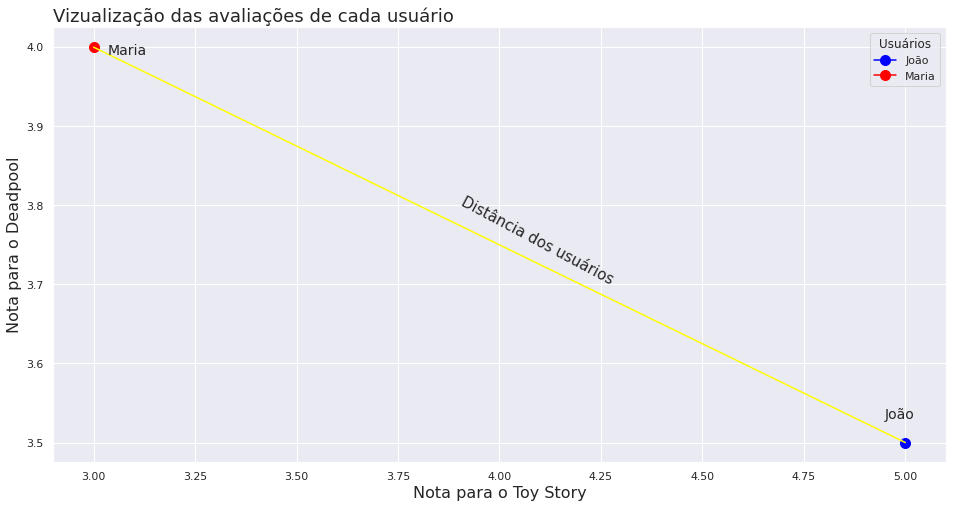

In [22]:
joao = [5, 3.5]
maria = [3, 4]

plt.figure(figsize = (16, 8))
plt.plot(joao[0], joao[1], marker = 'o', color = 'blue', markersize = 10)
plt.annotate('João', xy = (joao[0] - 0.05, joao[1] + 0.03), fontsize = 14)
plt.plot(maria[0], maria[1], marker = 'o', color = 'red', markersize = 10)
plt.annotate('Maria', xy = (maria[0] + 0.035, maria[1] - 0.01), fontsize = 14)
plt.legend(['João', 'Maria'], title = 'Usuários')


plt.plot([maria[0], joao[0]], [maria[1], joao[1]], color = 'yellow')
plt.annotate('Distância dos usuários', xy = (3.9, 3.7), rotation = -28, fontsize = 15)

plt.title('Vizualização das avaliações de cada usuário', fontsize = 18, loc = 'left')
plt.xlabel('Nota para o Toy Story', fontsize = 16)
plt.ylabel('Nota para o Deadpool', fontsize = 16)
plt.show()

Agora que conseguimos entender melhor a ideia, precisamos descobrir como calcular essa distância. A forma que utilizaremos será a da distância euclideana.

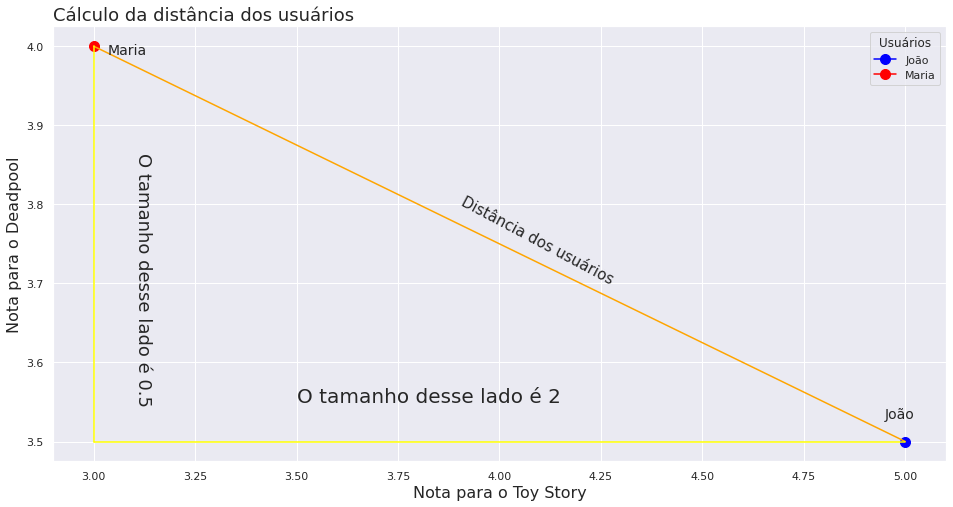

In [23]:
joao = [5, 3.5]
maria = [3, 4]

plt.figure(figsize = (16, 8))
plt.plot(joao[0], joao[1], marker = 'o', color = 'blue', markersize = 10)
plt.annotate('João', xy = (joao[0] - 0.05, joao[1] + 0.03), fontsize = 14)
plt.plot(maria[0], maria[1], marker = 'o', color = 'red', markersize = 10)
plt.annotate('Maria', xy = (maria[0] + 0.035, maria[1] - 0.01), fontsize = 14)
plt.legend(['João', 'Maria'], title = 'Usuários')


plt.plot([maria[0], joao[0]], [maria[1], joao[1]], color = 'orange')
plt.annotate('Distância dos usuários', xy = (3.9, 3.7), rotation = -28, fontsize = 15)

plt.plot([maria[0], joao[0]], [joao[1], joao[1]], color = 'yellow')
plt.annotate(f'O tamanho desse lado é {abs(maria[0] - joao[0])}', xy = (3.5, 3.55), fontsize = 20)
plt.plot([maria[0], maria[0]], [joao[1], maria[1]], color = 'yellow')
plt.annotate(f'O tamanho desse lado é {abs(maria[1] - joao[1])}', xy = (3.1, 3.55), fontsize = 18, rotation = -90)

plt.title('Cálculo da distância dos usuários', fontsize = 18, loc = 'left')
plt.xlabel('Nota para o Toy Story', fontsize = 16)
plt.ylabel('Nota para o Deadpool', fontsize = 16)
plt.show()

E como Pitágoras já nos mostrou, a hipotenusa ao quadrado é igual a soma dos quadrados dos catetos.

In [24]:
distancia_dos_usuarios_ao_quadrado = (0.5 ** 2) + (2 ** 2)
distancia_dos_usuarios = np.sqrt(distancia_dos_usuarios_ao_quadrado)
print(f'A distância de Maria e João é de {round(distancia_dos_usuarios, 2)}')

A distância de Maria e João é de 2.06


Agora vamos vizualizar essa distância em um gráfico

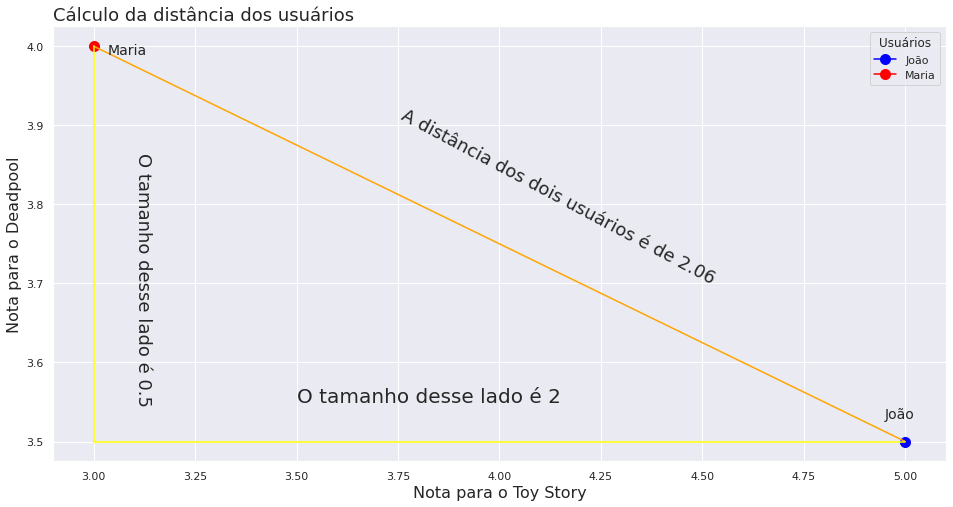

In [26]:
joao = [5, 3.5]
maria = [3, 4]

plt.figure(figsize = (16, 8))
plt.plot(joao[0], joao[1], marker = 'o', color = 'blue', markersize = 10)
plt.annotate('João', xy = (joao[0] - 0.05, joao[1] + 0.03), fontsize = 14)
plt.plot(maria[0], maria[1], marker = 'o', color = 'red', markersize = 10)
plt.annotate('Maria', xy = (maria[0] + 0.035, maria[1] - 0.01), fontsize = 14)
plt.legend(['João', 'Maria'], title = 'Usuários')


plt.plot([maria[0], joao[0]], [maria[1], joao[1]], color = 'orange')
plt.annotate(
    f'A distância dos dois usuários é de {round(distancia_dos_usuarios, 2)}',
    xy = (3.75, 3.7),
    rotation = -28,
    fontsize = 18
)

plt.plot([maria[0], joao[0]], [joao[1], joao[1]], color = 'yellow')
plt.annotate(f'O tamanho desse lado é {abs(maria[0] - joao[0])}', xy = (3.5, 3.55), fontsize = 20)
plt.plot([maria[0], maria[0]], [joao[1], maria[1]], color = 'yellow')
plt.annotate(f'O tamanho desse lado é {abs(maria[1] - joao[1])}', xy = (3.1, 3.55), fontsize = 18, rotation = -90)

plt.title('Cálculo da distância dos usuários', fontsize = 18, loc = 'left')
plt.xlabel('Nota para o Toy Story', fontsize = 16)
plt.ylabel('Nota para o Deadpool', fontsize = 16)
plt.show()

Sabendo disso nós calcularemos as distâncias para todos os usuários e encontraremos os mais similares

# Começando a encontrar usuários similares

Para isso, primeiramente precisaremos criar algum jeito de pegar as avaliações de cada usuário. Para isso criaremos uma função.

In [27]:
def get_users_ratings(user_id):
    user_ratings = ratings.query('userId == @user_id')
    user_ratings.set_index('movieId', inplace = True)
    return user_ratings
    
get_users_ratings(1).head()

,userId,rating,timestamp
movieId,,,
1,1,4.0,964982703
3,1,4.0,964981247
6,1,4.0,964982224
47,1,5.0,964983815
50,1,5.0,964982931


Agora criaremos outra função que junte a nota de dois usuários

In [28]:
def join_users_ratings(user_id1, user_id2):
    user_ratings_1 = get_users_ratings(user_id1)
    user_ratings_2 = get_users_ratings(user_id2)
    
    joined_users_ratings = user_ratings_1.join(user_ratings_2, lsuffix = '_1', rsuffix = '_2')
    joined_users_ratings.dropna(inplace = True)
    
    return {
        'n_similar_movies': len(joined_users_ratings),
        'movies': joined_users_ratings.index,
        'users_ratings': joined_users_ratings[['rating_1', 'rating_2']]
    }
    
    
join_users_ratings(1, 2)['users_ratings']

,rating_1,rating_2
movieId,,
333,5.0,4.0
3578,5.0,4.0


Aproveitando essa outra função, criaremos uma outra fórmula que ache a distância entre dois usuários

In [29]:
def get_distance_between_users(user_id1, user_id2, n_necessary_similar_movies = 1):
    users_ratings = join_users_ratings(user_id1, user_id2)
    
    # Verifica se os dois usuários tem filmes em comum o suficiente
    if users_ratings['n_similar_movies'] < n_necessary_similar_movies:
        return {
            'n_similar_movies': users_ratings['n_similar_movies'],
            'distance': None
        }
    
    distance = np.linalg.norm(
        users_ratings['users_ratings']['rating_1'] - users_ratings['users_ratings']['rating_2']
    )
    
    return {
        'n_similar_movies': users_ratings['n_similar_movies'],
        'distance': distance
    }

get_distance_between_users(1, 2)

{'distance': 1.4142135623730951, 'n_similar_movies': 2}

Agora que já temos como calcular a distância entre dois usuários, vamos criar uma outra função que ache usuários similares a um único usuário

In [30]:
def get_similars_users(user_id, k_neighbors = None):
    all_users = ratings['userId'].unique()
    all_users = np.delete(all_users, [np.where(all_users == user_id)])
    
    if k_neighbors:
        all_users = pd.DataFrame({'users': all_users}).sample(k_neighbors)
        all_users = all_users['users'].values
        
    users_distances = []
        
    for other_user in all_users:
        distance_stats = get_distance_between_users(user_id, other_user, 5)
        users_distances.append({
            'user_id': other_user,
            'distance': distance_stats['distance'],
            'n_similar_movies': distance_stats['n_similar_movies']
        })
        
    users_distances = pd.DataFrame(users_distances)
    users_distances = users_distances.sort_values(
        ['distance', 'n_similar_movies'],
        ascending = [True, False]
    )
    
    return users_distances


get_similars_users(1, 50).head()

,user_id,distance,n_similar_movies
24,319,1.118034,5
15,269,2.000000,7
35,26,2.236068,7
20,35,2.236068,6
7,535,2.449490,6


# Achando os filmes mais comuns entre os vizinhos

In [31]:
def get_movies(user_id, k_neighbors = None, n_necessary_ratings = 5):
    similar_users = get_similars_users(user_id, k_neighbors)
    similar_ratings = []
    
    for other_user in similar_users['user_id']:
        user_ratings = get_users_ratings(other_user)
        similar_ratings.append(user_ratings)
        
    similar_ratings = pd.concat(similar_ratings)
    similar_ratings = similar_ratings.join(
        movies[['rating', 'n_ratings']],
        lsuffix = '_user',
        rsuffix = '_all_users'
    )
    
    
    similar_ratings = similar_ratings.reset_index().groupby('movieId').mean()
    similar_ratings = similar_ratings[['rating_user', 'rating_all_users', 'n_ratings']]
    
    similar_ratings = similar_ratings.sort_values(
        ['rating_user', 'rating_all_users'],
        ascending = [False, False]
    )
    
    similar_ratings = similar_ratings.query('n_ratings >= @n_necessary_ratings')
    
    return similar_ratings.index
        
get_movies(1, 5)

Int64Index([ 1104,   318,   898,   176,   475,   858, 62336,   930,  3508,
              912,
            ...
              355,  5804,  7117,  3826,  1972,  1644,  6951,  4158,  2392,
             2422],
           dtype='int64', name='movieId', length=416)

Agora que achamos filmes recomendáveis, vamos criar uma função de sugestão de filmes

In [32]:
def suggest_movies(user_id, k_neighbors = None):
    recomended_movies = get_movies(user_id, k_neighbors, 50)
    recomended_movies = movies.loc[recomended_movies]
    watched_movies = get_users_ratings(user_id).index
    recomended_movies = recomended_movies.drop(watched_movies, errors = 'ignore')
    
    return recomended_movies


suggest_movies(442, 100).head()

,title,genres,rating,n_ratings
movieId,,,,
2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War,4.147727,88.0
923,Citizen Kane (1941),Drama|Mystery,4.043478,69.0
1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy,4.161765,136.0
318,"Shawshank Redemption, The (1994)",Crime|Drama,4.429022,317.0
109487,Interstellar (2014),Sci-Fi|IMAX,3.993151,73.0


# Testando nosso algoritmo

## Criando o meu usuário

In [33]:
user_ratings = [
    {'movieId': 176601, 'rating': 4.0},
    {'movieId': 527, 'rating': 5.0},
    {'movieId': 117176, 'rating': 4.5},
    {'movieId': 356, 'rating': 4.5},
    {'movieId': 55721, 'rating': 4.5},
    {'movieId': 174055, 'rating': 3.0}
]

user_ratings = pd.DataFrame(user_ratings)
user_ratings['userId'] = ratings['userId'].max() + 1
user_ratings['timestamp'] = 0

ratings = pd.concat([ratings, user_ratings])
ratings.tail()

,userId,movieId,rating,timestamp
1,611,527,5.0,0
2,611,117176,4.5,0
3,611,356,4.5,0
4,611,55721,4.5,0
5,611,174055,3.0,0


In [34]:
np.random.seed(SEED)
suggest_movies(611).head()

,title,genres,rating,n_ratings
movieId,,,,
318,"Shawshank Redemption, The (1994)",Crime|Drama,4.429022,317.0
858,"Godfather, The (1972)",Crime|Drama,4.289062,192.0
2959,Fight Club (1999),Action|Crime|Drama|Thriller,4.272936,218.0
1276,Cool Hand Luke (1967),Drama,4.271930,57.0
750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,4.268041,97.0


Os filmes recomendados eu precisaria ver depois para avaliar o algoritmo, mas parecem seguir o meu estilo de filmes que eu assistiria.

## Separando por tempo

Para isso separaremos pelo "timestamp" as avaliações e depois checaremos se o usuário assistiu e gostou do filme recomendado

In [35]:
q3 = ratings['timestamp'].quantile(0.75)
print(f'O terceiro quartio é de {q3}')

O terceiro quartio é de 1435994135.75


In [36]:
select_before_q3 = ratings['timestamp'] < q3
select_later_q3 = ratings['timestamp'] > q3
test_ratings = ratings[select_later_q3]
ratings = ratings[select_before_q3]

print(f'Treinaremos com {len(ratings)} elementos e testaremos com {len(test_ratings)} elementos')

Treinaremos com 75631 elementos e testaremos com 25211 elementos


In [37]:
def test_user(user_id):
    suggested_movies = list(suggest_movies(user_id, 50).index)
    later_watched_movies = test_ratings.query('userId == @user_id')[['movieId', 'rating']].set_index('movieId')
    accuracy_score = []
    
    for suggested_movie_id in suggested_movies:
        if suggested_movie_id in later_watched_movies.index:
            suggested_movie_avaliation = later_watched_movies.loc[suggested_movie_id]['rating']
            accuracy_score.append(suggested_movie_avaliation / 5)
            
    return np.array(accuracy_score)

print(f'A avaliação do nosso algoritmo com somente um usuário foi de {round(test_user(15).mean() * 100, 2)}%')

A avaliação do nosso algoritmo com somente um usuário foi de 72.34%


# Conclusão com um intervalo de confiança

In [38]:
all_testable_users = set(list(ratings['userId'].unique()) + list(test_ratings['userId'].unique()))
all_testable_users = [
    user_id
    for user_id in all_testable_users
    if user_id in ratings['userId'].unique() and user_id in test_ratings['userId'].unique()
]
all_testable_users = np.array(all_testable_users)
all_testable_users

array([ 15,  21,  68, 103, 119, 177, 193, 249, 282, 292, 318, 326, 414,
       443, 448, 462, 509, 522, 537])

In [40]:
from tqdm import tqdm

algorithm_scores = []

for user_id in tqdm(all_testable_users):
    for i in test_user(user_id):
        algorithm_scores.append(i)
        
algorithm_scores = np.array(algorithm_scores)
    
print(f'\nOs usuários avaliaram os filmes recomendados em média com {round(algorithm_scores.mean() * 100, 2)}%')

100%|██████████| 19/19 [00:15<00:00,  1.23it/s]


Os usuários avaliaram os filmes recomendados em média com 74.15%


In [42]:
from scipy.stats import norm
significance = 0.05
confiance = 1 - significance
probability = (confiance / 2) + 0.5
Z = norm.ppf(probability)
n = len(algorithm_scores)
std = algorithm_scores.std()
mean = algorithm_scores.mean()
sigma = std / np.sqrt(n)
e = Z * sigma
limits = (mean - e, mean + e)

print(f'''A média de avaliação dos filmes sugeridos pelo nosso algoritmo foi de {round(mean * 100, 2)}%.
Com 95% de confiança e 5% de significância, afirmamos que em produção, o nosso algoritmo teria uma 
taxa de acerto entre: ({round(limits[0] * 100, 2)}% e {round(limits[1] * 100, 2)}%).''')

A média de avaliação dos filmes sugeridos pelo nosso algoritmo foi de 74.15%.
Com 95% de confiança e 5% de significância, afirmamos que em produção, o nosso algoritmo teria uma 
taxa de acerto entre: (72.12% e 76.18%).
